## Import Statements

In [2]:
import pandas as pd
import numpy as np
import nltk 
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import string
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from textblob import TextBlob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
nltk.download('words')
nltk.download('stopwords')
words = nltk.corpus.words.words()
sw = stopwords.words('english')

## Load review data, group reviews by product, and remove NaN's

In [ ]:
path_to_datasets = " " #please insert the path_to_dataset here
df = pd.read_json(path_to_datasets + 'Toys_and_Games_Reviews_training.json', lines=True)
#df = pd.read_json('/Users/ybchoi/Dropbox (Dartmouth College)/classes/q5_fall2020/ML&stats/dataAll/Toys_and_Games_Reviews_training.json', lines=True)

## Review count 

In [ ]:
# count review number
df_count = df.groupby(["asin"])['reviewText'].count().reset_index(name="count")
df_count.head()
import matplotlib.pyplot as plt
hist = df_count.hist(bins = 100)
plt.yscale('log')
plt.title('')

In [ ]:
#remove items with NaN reviews
clean_df = df[df['reviewText'].notna()]
df2 = clean_df[['asin', 'overall', 'reviewText', 'summary']]

In [ ]:
#Group reviews by product

avg = df2[['asin', 'overall']].groupby('asin').mean()
# assian traget=1 if averaged overall>4.5 and target=0 otherwise
avg2 = avg.assign(
    Target = lambda dataframe: dataframe['overall'].map(lambda overall: "1" if overall >4.5 else "0") 
)
avg2 = avg2.rename_axis("asin").reset_index()
avg2.columns = ['asin','overall_avg', 'Target']

# select coloumns
df3 = df2[['asin', 'overall', 'reviewText', 'summary']]

df4 = df3.groupby('asin')['reviewText'].apply(' '.join).reset_index()

### Sentiment feature generation using vaderSentiment Analysis 

In [ ]:
#function to print sentiments from cleanedText. 
    #source used: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
    #resources used: https://pypi.org/project/vaderSentiment/ 
    #resources used: https://github.com/cjhutto/vaderSentiment#about-the-scoring
    #resource: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

sid = SentimentIntensityAnalyzer()
#df['vaderTest'] = df['reviewText'].apply(lambda review: sid.polarity_scores(review))
dft['scores'] = dft['reviewText'].apply(lambda review: sid.polarity_scores(review))
dft['compound']  = dft['scores'].apply(lambda score_dict: score_dict['compound'])
dft['comp_score'] = dft['compound'].apply(lambda c: 'Positive' if c >0 else 'Negative' if c <0 else 'Neutral')

dft.head(20)

dft.to_csv('dft_vaderSentimentAdded.csv')
dft = pd.read_csv('dft_vaderSentimentAdded.csv')

### Sentiment feature generation using TextBlobSentiment Analysis 

In [ ]:
# function to print textblob results of reviewText. 
    #resource: https://medium.com/@b.terryjack/nlp-pre-trained-sentiment-analysis-1eb52a9d742c

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

def detect_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

dft['polarity'] = dft['reviewText'].apply(detect_polarity)
dft['subjectivity'] = dft['reviewText'].apply(detect_subjectivity)

In [ ]:
dft['polarity'] = dft['reviewText'].apply(detect_polarity)
dft['subjectivity'] = dft['reviewText'].apply(detect_subjectivity)

In [ ]:
dft.to_csv('dft_TextBlobSentAdded.csv')

### Sentiment Data visualization

In [ ]:
#Resource: https://towardsdatascience.com/having-fun-with-textblob-7e9eed783d3f
x=dft['Target'].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Review Rating Distribution")
plt.ylabel('Count')
plt.xlabel('Review Rating')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

In [ ]:
#histogram of vader compound scores
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(dft.compound, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('')
plt.ylabel('Count')
plt.title('Histogram of vaderSentiments')
plt.show();

In [ ]:
#boxplot of vader compound scores by overall ratings
plt.figure(figsize=(10,6))
sns.boxenplot(x='overall', y='compound', data=dft)
plt.show();

In [ ]:
#histogram of TextBlob polairty(sentiment) scores
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(dft.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

In [ ]:
#boxplot of TextBlob polarity scores by overall ratings
plt.figure(figsize=(10,6))
sns.boxenplot(x='overall', y='polarity', data=dft)
plt.show();

In [ ]:
#bargraph of TextBlob polarity scores by classes 
sns.barplot(x='Target', y='polarity', data=sample_dft)

In [ ]:
#boxplot of TextBlob subjectivity scores by overall ratings
plt.figure(figsize=(10,6))
sns.boxenplot(x='overall', y='subjectivity', data=dft)
plt.show();

In [ ]:
#bargraph of TextBlob subjectivity scores by classes 
sns.barplot(x='Target', y='subjectivity', data=sample_dft)

In [ ]:
Senti = pd.read_csv('dft_TextBlobSentAdded.csv')
avgSenti = Senti[['asin', 'sentiment_scores']].groupby('asin').mean()

In [ ]:
# add target and count to df4
dft = df4.merge(avg2, on = 'asin', how ='left')
dft = dft.merge(df_count, on = 'asin', how ='left')
dft = dft.merge(avgSenti, on = 'asin', how ='left')

# Feature Generation
### Wordclouds, BoW, TFIDF, review characteristics, and Sentiment Analysis

In [9]:
#Load saved csv
dft = pd.read_csv('df_combined_text.csv')

### Visualizing n-grams as wordclouds by target class

In [ ]:
##source: https://www.kaggle.com/peterwittek/wordclouds-of-titles-and-abstracts-with-n-grams
## source: https://medium.com/@jiayangcheng21/creating-bigram-and-trigram-word-cloud-for-ios-app-reviews-using-pythons-nltk-natural-language-55eaec5997af
###source: https://www.datacamp.com/community/tutorials/wordcloud-python

import nltk
from wordcloud import WordCloud, STOPWORDS

#subsetting data by target class
dft_classOne = dft[dft['Target']==1]
#dft_classOne.head()
dft_classZero = dft[dft['Target']==0]
#dft_classZero.head()

text_classOne = " ".join(review for review in dft_classOne['reviewText'])
print ("There are {} words in the combination of all review.".format(len(text_classOne)))

text_classZero = " ".join(review for review in dft_classZero['reviewText'])
print ("There are {} words in the combination of all review.".format(len(text_classZero)))

#generate wordclouds

wordcloud_quadri_classOne = WordCloud(background_color ='white', collocation_threshold = 4).generate(text_classOne)

wordcloud_quadri_classZero = WordCloud(background_color ='white', collocation_threshold = 4).generate(text_classZero)

#import matplotlib.pyplot as plt
# Display the generated world cloud image for target class == 1
plt.title('Most Frequently Occurring n-grams for Awesome Class')
plt.imshow(wordcloud_quadri_classOne, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud_quadri_classOne.to_file("WordCloud_Awsome.png")

# Display the generated world cloud image for target class == 0
plt.title('Most Frequently Occurring n-grams for Not Awesome Class')
plt.imshow(wordcloud_quadri_classZero, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud_quadri_classZero.to_file("WordCloud_notAwsome.png")

### BoW feature generation and visualization

In [108]:
# create a count vectorizer object
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
# fit the count vectorizer using the text data
text_counts = count_vectorizer.fit_transform(dft['CleanedText'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()  

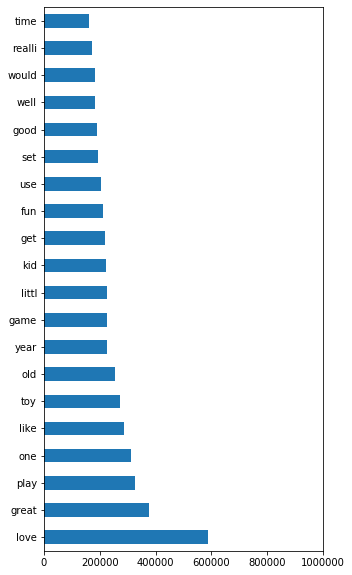

In [30]:
#Visualize BoW feature count distribution

# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
freq= pd.Series((' '.join(dft['CleanedText']).split())).value_counts().sort_values(ascending = False)
top_vacab = freq.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10),xlim= (0,1000000))

### TIFDF feature generation and visualization

In [ ]:
#create TFIDF vector
tf=TfidfVectorizer()
text_tf= tf.fit_transform(dft['reviewText'])

In [ ]:
#Visualize TFIDF feature value distribution
#Citation: https://buhrmann.github.io/tfidf-analysis.html

from sklearn.pipeline import Pipeline
vec_pipe = Pipeline([('tfidf',TfidfVectorizer())])
Xtr = vec_pipe.fit_transform(dft['reviewText'])
vec = vec_pipe.named_steps['tfidf']
features = vec.get_feature_names()

In [ ]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [ ]:
feats = top_feats_by_class(Xtr, dft['Target'], features, min_tfidf=0.1, top_n=25)

In [ ]:
plot_tfidf_classfeats_h(feats)

### Features based on product review characteristics

In [12]:
##Citation: https://www.kaggle.com/shaz13/feature-engineering-for-nlp-classification#Pause-And-Think!

not_awesome_review = dft[dft['Target'] == 0]
awesome_review = dft[dft['Target'] == 1]

not_awesome_review['length'] = not_awesome_review['reviewText'].apply(lambda x : len(x))
awesome_review['length'] = awesome_review['reviewText'].apply(lambda x : len(x))
dft['length'] = dft['reviewText'].apply(lambda x : len(x))

not_awesome = not_awesome_review['length'].values
awesome = awesome_review['length'].values
data = [awesome, not_awesome]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff4b90f3050>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff4a94db250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff4885b5e90>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff4bd14d190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff4ba698750>,
 'means': []}

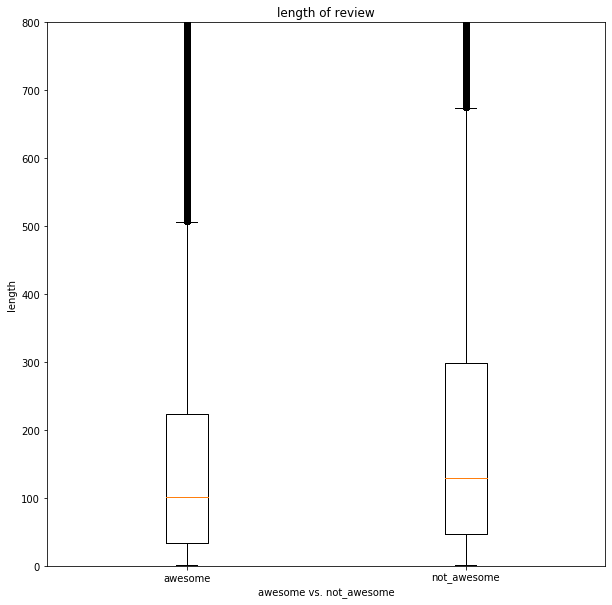

In [13]:
#box plot of feature for awesome vs not awesome products
fig1, ax1 = plt.subplots(figsize = (10,10))
ax1.set_title('length of review')
ax1.set_xlabel('awesome vs. not_awesome')
ax1.set_ylabel('length')
ax1.set_xticklabels(['awesome', 'not_awesome'])
ax1.set_ylim([0, 800])
ax1.boxplot(data)

In [ ]:
#generate features based on words, length, punctuation, etc.
for df in ([dft]):
    df['length'] = df['reviewText'].apply(lambda x : len(x))
    df['capitals'] = df['reviewText'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['length']),axis=1)
    df['num_exclamation_marks'] = df['reviewText'].apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['reviewText'].apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df['reviewText'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['reviewText'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words'] = df['reviewText'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['reviewText'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['num_smilies'] = df['reviewText'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    df['num_sad'] = df['reviewText'].apply(lambda comment: sum(comment.count(w) for w in (':-<', ':()', ';-()', ';(')))

In [ ]:
#generate features based on the parts of speech
for df in ([dft]):
    df['nouns'], df['adjectives'], df['verbs'] = zip(*df['reviewText'].progress_apply(
        lambda comment: tag_part_of_speech(comment)))
    df['nouns_vs_length'] = df['nouns'] / df['length']
    df['adjectives_vs_length'] = df['adjectives'] / df['length']
    df['verbs_vs_length'] = df['verbs'] /df['length']
    df['nouns_vs_words'] = df['nouns'] / df['num_words']
    df['adjectives_vs_words'] = df['adjectives'] / df['num_words']
    df['verbs_vs_words'] = df['verbs'] / df['num_words']
    # More Handy Features
    df["count_words_title"] = df["reviewText"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df["mean_word_len"] = df["reviewText"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['punct_percent']= df['num_punctuation']*100/df['num_words']

# Testing classifier-feature combinations

### running Logit classifier on vaderSentiment avg

In [ ]:
#averaging vader compound scores by product
dft_vd = dft[['asin', 'compound']].groupby('asin').mean()
Target = dft[['asin','Target']].groupby('asin').mean()
print(dft1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dft_vd, Target, test_size=0.2, random_state=1)

#Create a Classifier
clf = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("LASSO-LR Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

scores = clf.score(X_test, y_test) # accuracy
print(scores)


print(classification_report(y_test,y_pred))

### running Logit classifier on TextBlob avg

In [ ]:
#averaging TextBlob scores by product
dft_tb = dft[['asin', 'subjectivity', 'polarity']].groupby('asin').mean()
Target = dft[['asin','Target']].groupby('asin').mean()
print(dft2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dft_tb, Target, test_size=0.2, random_state=1)

#Create a Classifier
clf = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("LASSO-LR Accuracy:",metrics.accuracy_score(y_test, y_pred))

scores = clf.score(X_test, y_test) # accuracy
print(scores)

print(classification_report(y_test,y_pred))

### Bag of Words-multinomial NB

In [ ]:
# training data
X_train = text_counts
y_train = dft['Target']

# Create a Classifier
clf_BoW_NB = MultinomialNB()

# cross-validation
scores = cross_val_score(clf_BoW_NB, X_train, y_train, cv=10, scoring='precision')
scores2 = cross_val_score(clf_BoW_NB, X_train, y_train, cv=10, scoring='recall')
scores3 = cross_val_score(clf_BoW_NB, X_train, y_train, cv=10, scoring='f1')

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

### Bag of Words- logisticRegression

In [ ]:
# Create a Classifier
clf_BoW_LR = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel

# cross-validation
scores = cross_val_score(clf_BoW_LR, X_train, y_train, cv=10, scoring='precision')
scores2 = cross_val_score(clf_BoW_LR, X_train, y_train, cv=10, scoring='recall')
scores3 = cross_val_score(clf_BoW_LR, X_train, y_train, cv=10, scoring='f1')

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

### add count and sentiment score into text_tf (sparse matrix)

In [ ]:
# add count into text_tf (sparse matrix)
from scipy import sparse
text_tf_count = sparse.hstack((text_tf,np.array(dft['count'])[:,None]))
text_tf_senti = sparse.hstack((text_tf,np.array(dft['sentiment_scores'])[:,None]))

### TFIDF-Bagging

In [ ]:
# training data
X_train_TF = text_tf
y_train_TF = dft['Target']

##source: https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de
seed = 1075
np.random.seed(seed)

#Create a Classifier
clf = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel
bagging_clf = BaggingClassifier(clf, max_samples=0.2, max_features=10, random_state=seed)
scores = cross_val_score(bagging_clf, X_train_TF, y_train_TF, cv=10, n_jobs=-1)
scores2 = cross_val_score(bagging_clf, X_train_TF, y_train_TF, cv=10, scoring='recall')
scores3 = cross_val_score(bagging_clf, X_train_TF, y_train_TF, cv=10, scoring='f1')

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

### TFIDF-multinomial NB

In [ ]:
# Create a Classifier
clf_TF_NB = MultinomialNB()

# cross-validation
scores = cross_val_score(clf_TF_NB, X_train_TF, y_train_TF, cv=10, scoring='precision')
scores2 = cross_val_score(clf_TF_NB, X_train_TF, y_train_TF, cv=10, scoring='recall')
scores3 = cross_val_score(clf_TF_NB, X_train_TF, y_train_TF, cv=10, scoring='f1')

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

### TFIDF-logisticRegression

In [ ]:
# Create a Classifier
clf_TF_LR = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel

# cross-validation
scores = cross_val_score(clf_TF_LR, X_train_TF, y_train_TF, cv=10, scoring='precision')
scores2 = cross_val_score(clf_TF_LR, X_train_TF, y_train_TF, cv=10, scoring='recall')
scores3 = cross_val_score(clf_TF_LR, X_train_TF, y_train_TF, cv=10, scoring='f1')

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

### TFIDF-SMOTE-logistic regression

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train_TF, y_train_TF)

scores = cross_val_score(clf_TF_LR, X, y, cv=10, scoring='precision')
scores2 = cross_val_score(clf_TF_LR, X, y, cv=10, scoring='recall')
scores3 = cross_val_score(clf_TF_LR, X, y, cv=10, scoring='f1')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

### TFIDF+Senti - logistic regression

In [ ]:
X_train_TF = text_tf_senti
y_train_TF = dft['Target']

# cross-validation
scores = cross_val_score(clf_TF_LR, X_train_TF, y_train_TF, cv=10, scoring='precision')
scores2 = cross_val_score(clf_TF_LR, X_train_TF, y_train_TF, cv=10, scoring='recall')
scores3 = cross_val_score(clf_TF_LR, X_train_TF, y_train_TF, cv=10, scoring='f1')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

### TFIDF-Late Fusion

In [ ]:
X = text_tf
y = dft['Target']

clflg = LogisticRegression(C=1, penalty='l1', solver='liblinear')
clfnb = MultinomialNB()
clfrf = RandomForestClassifier(n_estimators=50, random_state=1)
clfdt = DecisionTreeClassifier(random_state=0)

alphas = np.linspace(0, 1, 5)

clfs = [clflg, clfnb, clfrf, clfdt]

# probability threshold
pt = 0.5

cv = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
for alpha1 in alphas:
    for alpha2 in alphas:
        if(alpha1 + alpha2>1):
            continue
        for alpha3 in alphas:
            if(alpha1 + alpha2 + alpha3 > 1):
                continue
            f1scores = []
            for (train_index, test_index) in cv.split(X, y):                
                clflg.fit(X[train_index, :], np.array(y)[train_index])
                clfnb.fit(X[train_index, :], np.array(y)[train_index])
                clfrf.fit(X[train_index, :], np.array(y)[train_index])
                clfdt.fit(X[train_index, :], np.array(y)[train_index])
                prob = (alpha1*clfs[0].predict_proba(X[test_index, :]) + \
                        alpha2*clfs[1].predict_proba(X[test_index, :]) + \
                        alpha3*clfs[2].predict_proba(X[test_index, :]) + \
                       (1 - alpha1 - alpha2 - alpha3)*clfs[3].predict_proba(X[test_index, :]))[:, 1]
                #print(prob)
                y_pred = np.zeros(len(prob))
                idx = (prob>=pt)
                y_pred[idx] = 1
                #print(classification_report(np.array(y)[test_index], y_pred))
                f1scores.append(f1_score(np.array(y)[test_index], y_pred))
            print('alpha1 = ', alpha1, 'alpha2 = ', alpha2, 'alpha3 = ', alpha3)
            print(f1scores)
            f1scores = np.array(f1scores)
            print('mean f1 = ', f1scores.mean())

# Classification Accuracy Comparisons

### ROC Curve for Comparison of Classification-Feature Pairs

#### original feature-classifier combinations for deliverable 3

In [ ]:
##BoW vector generation
token = RegexpTokenizer(r'[a-zA-Z]+')
count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)

# fit the count vectorizer using the text data
text_counts = count_vectorizer.fit_transform(dft['reviewText'])

In [ ]:
#generate test and training set for BoW
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, dft['Target'], test_size=0.3, random_state=1)

In [ ]:
#TFIDF vector generation
tf=TfidfVectorizer()
text_tf= tf.fit_transform(dft['reviewText'])


In [ ]:
#generate test and training set for TFIDF
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    text_tf, dft['Target'], test_size=0.2, random_state=1)

In [ ]:
#train each classifier-feature pair combination
clf1 = MultinomialNB()
clf1.fit(X_train, y_train)
probas1 = clf1.predict_proba(X_test)

clf2 = LogisticRegression(C=1, penalty='l1', solver='liblinear')
clf2.fit(X_train,y_train)
probas2 = clf2.predict_proba(X_test)

clf4 = MultinomialNB()
clf4.fit(X_train2, y_train2)
probas4 = clf4.predict_proba(X_test2)

clf5 = LogisticRegression(C=1, penalty='l1', solver='liblinear')
clf5.fit(X_train2,y_train2)
probas5 = clf5.predict_proba(X_test2)

#### new feature-classifier combinations for deliverable 4

In [ ]:
clf5 = LogisticRegression(C=2, penalty='l1', solver='liblinear')
clf5.fit(X_train2,y_train2)
probas5 = clf5.predict_proba(X_test2)

clf6 = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel
oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(X_train2, y_train2)
clf6.fit(X, y)
probas6 = clf6.predict_proba(X_test2)

clf1 = LogisticRegression(C=1, penalty='l1', solver='liblinear')
clf2 = GaussianNB()
clf3 = RandomForestClassifier(n_estimators=50, random_state=1)
eclf = VotingClassifier(estimators=[('lr', clf1),('rf', clf3), ('gnb', clf2)],voting='hard')
eclf.fit(X_train2.toarray(), y_train2)
probas7 = eclf.predict_proba(X_test2)

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}
grid = GridSearchCV(
    estimator=LogisticRegression(penalty='l1', solver='liblinear'), 
    param_grid= {'C': [1.0, 100], 'class_weight': [None, 'balanced']}
    , cv=5)
grid = grid.fit(X_train2, y_train2)
probas8 = grid.predict_proba(X_test2)

In [ ]:
f = plt.figure(figsize=[10,10]) 
plt.plot(roc_curve(y_test2, probas5[:,1])[0], roc_curve(y_test2, probas5[:,1])[1], label = 'Logit TFIDF')
plt.plot(roc_curve(y_test2, probas6[:,1])[0], roc_curve(y_test2, probas6[:,1])[1], label = 'Logit TFIDF SMOTE')
plt.plot(roc_curve(y_test2, probas7[:,1])[0], roc_curve(y_test2, probas7[:,1])[1], label = 'Voting Classifier')
plt.plot(roc_curve(y_test2, probas8[:,1])[0], roc_curve(y_test2, probas8[:,1])[1], label = 'Logit TFIDF GridCV')

plt.title('ROC Curve for Different Classifiers')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.legend(bbox_to_anchor=(1.0, .5))

plt.show()

### Confusion Matrix for Best Model Prediction (TFIDF - Logit combination)

In [ ]:
from sklearn.metrics import confusion_matrix

##implementation pulled from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
classifier = LogisticRegression(C=2, penalty='l1', solver='liblinear').fit(X_train2, y_train2)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Prediction csv (not includes SMOTE / Late Fusion / GridSearch / cross-validation)

In [ ]:
toy_test = pd.read_json('/Users/chenjiqing/Public/2020_Fall_term/data/Toys_and_Games_Reviews_test.json', lines=True)

In [ ]:
vader_sntimentscore_test = pd.read_csv('dft_test_vaderSentimentAdded.csv')
avg_vader_sntimentscore_test = vader_sntimentscore_test[['asin', 'sentiment_scores']].groupby('asin').mean()
avg_vader_sntimentscore_test

In [ ]:
# select coloumns
toy_test2 = toy_test[['asin', 'reviewText']]
clean_toy_test = toy_test2[toy_test2['reviewText'].notna()]
print(clean_toy_test.shape)
clean_toy_test2 = clean_toy_test.groupby('asin')['reviewText'].apply(' '.join).reset_index()
clean_toy_test2.head()
print(clean_toy_test2.shape)
print(clean_toy_test2.head())

In [ ]:
tf2=TfidfVectorizer(vocabulary = tf.vocabulary_)
text_tf2= tf2.fit_transform(clean_toy_test2['reviewText'])
text_tf_senti_test = sparse.hstack((text_tf2,np.array(avg_vader_sntimentscore_test['sentiment_scores'])[:,None]))
print(text_tf_senti_test)

In [ ]:
y_toy_test_pred = clf_TFIDF_vader.predict(text_tf_senti_test)

In [ ]:
dft_predict1 = clean_toy_test2[['asin']]
print(dft_predict1)
dft_predict1['preds'] = y_toy_test_pred
print(dft_predict1)
dft_predict1.to_csv('predictions.csv', index=False)